# Test Generative Adverserial Network

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, Dropout
from keras.layers import Reshape, UpSampling2D, MaxPooling2D, Activation
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import SGD
from keras.utils import to_categorical
from PIL import Image

Using TensorFlow backend.


In [2]:
g_model = load_model('./model/generator.h5')
d_model = load_model('./model/discriminator.h5')

In [3]:
def combine_model(g, d):
    model = Sequential()
    model.add(g)
    model.add(d)
    return model

In [4]:
def combine_images(generated_images):
    num = generated_images.shape[0]
    width = int(np.sqrt(num))
    height = int(np.ceil(float(num)/width))
    shape = generated_images.shape[1:3]
    image = np.zeros((height*shape[0], width*shape[1]),
                     dtype=generated_images.dtype)
    for index, img in enumerate(generated_images):
        i = int(index/width)
        j = index % width
        image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
            img[:, :, 0]
    return image

## Generate gambar
pada fungsi ini gambar bisa digenerate dengan input BATCH_SIZE yang menunjukan jumlah gambar yang akan digenerate. parameter nice digunakan untuk menghasilkan gambar-gambar dengan kualitas terbaik

In [5]:
def generate_images(g, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size, z_size))
    generated_images = g.predict(noise, verbose=1)
    image = combine_images(generated_images)
    filename = "generated_image.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

100/100 [==============================] - 1s 12ms/step


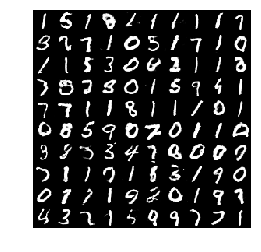

In [6]:
images = generate_images(g_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

In [7]:
def generate_best_images(g, d, batch_size):
    z_size = g.layers[0].input_shape[1]
    noise = np.random.uniform(-1, 1, (batch_size*20, z_size))

    generated_images = g.predict(noise, verbose=1)
    d_pret = d.predict(generated_images, verbose=1)

    index = np.arange(0, batch_size*20)
    index.resize((batch_size*20, 1))

    pre_with_index = list(np.append(d_pret, index, axis=1))
    pre_with_index.sort(key=lambda x: x[0], reverse=True)

    nice_images = np.zeros((batch_size,) + generated_images.shape[1:3], dtype=np.float32)
    nice_images = nice_images[:, :, :, None]

    for i in range(batch_size):
        idx = int(pre_with_index[i][1])
        nice_images[i, :, :, 0] = generated_images[idx, :, :, 0]

    image = combine_images(nice_images)
    filename = "generated_image_best.png"
    image = image*127.5+127.5
    Image.fromarray(image.astype(np.uint8)).save(filename)
    return image

2000/2000 [==============================] - 0s 57us/step


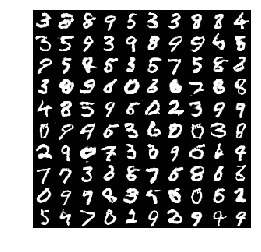

In [40]:
images = generate_best_images(g_model, d_model, 100)
plt.imshow(images, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

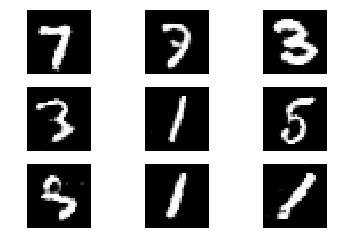

In [46]:
seed = np.random.uniform(-1, 1, (9, 100))
images = g_model.predict(seed)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.imshow(np.reshape(images[i], (28,28,)),cmap=plt.get_cmap('gray'))
    plt.axis('off')
plt.show()

## Tebak label
fungsi ini berguna untuk menebak label dari sebuah gambar dengan ukuran (1,28,28,1). model yang digunakan untuk mengklasifikasikan gambar adalah CNN yang sudah di train sebelumnya

In [10]:
def mnist_classifier():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [11]:
def train_classifier(model, batch_size, epochs):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    #(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
    
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    
    X_train /= 255
    X_test /= 255
    
    X_train = X_train[:, :, :, None]
    X_test = X_test[:, :, :, None]
    
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    model.fit(X_train, y_train, batch_size=batch_size,
          epochs=epochs,verbose=2,validation_data=(X_test, y_test))
    score = model.evaluate(X_test, y_test, verbose=0)
    print('Test accuracy:', score[1])
    return model

In [12]:
batch = 500
mnist_model = mnist_classifier()
mnist_model = train_classifier(mnist_model, batch, 15)

mnist_model.save('./model/mnist_model.h5')

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
 - 3s - loss: 0.3964 - acc: 0.8810 - val_loss: 0.0783 - val_acc: 0.9749
Epoch 2/15
 - 2s - loss: 0.1094 - acc: 0.9676 - val_loss: 0.0469 - val_acc: 0.9849
Epoch 3/15
 - 2s - loss: 0.0778 - acc: 0.9773 - val_loss: 0.0388 - val_acc: 0.9866
Epoch 4/15
 - 2s - loss: 0.0640 - acc: 0.9806 - val_loss: 0.0362 - val_acc: 0.9876
Epoch 5/15
 - 2s - loss: 0.0542 - acc: 0.9837 - val_loss: 0.0369 - val_acc: 0.9889
Epoch 6/15
 - 2s - loss: 0.0483 - acc: 0.9857 - val_loss: 0.0311 - val_acc: 0.9902
Epoch 7/15
 - 2s - loss: 0.0437 - acc: 0.9867 - val_loss: 0.0297 - val_acc: 0.9901
Epoch 8/15
 - 2s - loss: 0.0381 - acc: 0.9882 - val_loss: 0.0263 - val_acc: 0.9906
Epoch 9/15
 - 2s - loss: 0.0344 - acc: 0.9892 - val_loss: 0.0280 - val_acc: 0.9910
Epoch 10/15
 - 2s - loss: 0.0315 - acc: 0.9900 - val_loss: 0.0286 - val_acc: 0.9912
Epoch 11/15
 - 2s - loss: 0.0290 - acc: 0.9907 - val_loss: 0.0294 - val_acc: 0.9906
Epoch 12/15
 - 2s - loss: 0.0260 - 

# Proses pengujian
inputnya berupa variabel seed yang berukuran (1,100) dengan rentang nilai [-1,1) 

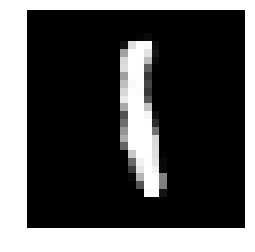

Predicted label is [1]


In [13]:
seed = np.random.uniform(-1, 1, (1, 100))

image = g_model.predict(seed)
plt.imshow(np.reshape(image, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

pred = mnist_model.predict(image)
label = np.argmax(pred, axis=1)
print('Predicted label is %s' % label)

## Uji coba 
generate 1000 gambar dan tebak labelnya, lalu masukkan kedalam dictionary seednya berdasarkan arraynya

In [14]:
seed = np.random.uniform(-1, 1, (5000, 100))
print(seed.shape)

images = g_model.predict(seed)
print(images.shape)

(5000, 100)
(5000, 28, 28, 1)


In [15]:
# Predict label
pred = mnist_model.predict(images)
y_preds = np.argmax(pred, axis=1)

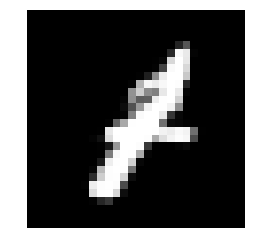

Predicted label is 7


In [16]:
id = 5
plt.imshow(np.reshape(images[id], (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()
print('Predicted label is %s' % y_preds[id])

In [17]:
# variabel untuk menyimpan nilai seed dari tiap label
labels =  {i: [] for i in range(10)}

for idx, l in enumerate(y_preds):
    labels[l].append(seed[idx])

In [19]:
print(labels.keys())
means =  {i: np.mean(np.array(labels[i]), axis=0) for i in range(10)}

for i in range(10):
    print(np.array(labels[i]).shape)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
(776, 100)
(1751, 100)
(372, 100)
(524, 100)
(115, 100)
(439, 100)
(41, 100)
(801, 100)
(43, 100)
(138, 100)


## Image generator
dengan menggunakan rata-rata dari seed sebelumnya, nilai rata-rata tersebut digunakan untuk membuat gambar baru. hasil rata-rata dikalingan dengan sebuah bilangan untuk menghasilkan gambar lainya

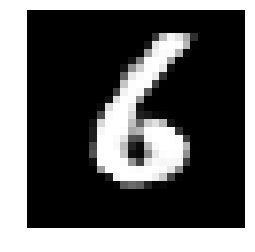

In [21]:
num = 6
mean_seed = np.reshape(means[num], (1, 100))
img = g_model.predict(mean_seed)

plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

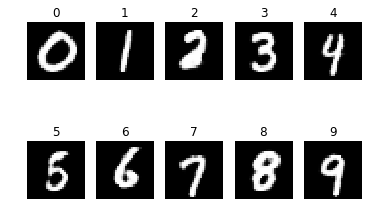

In [22]:
for i in range(10):
    mean_seed = np.reshape(means[i], (1, 100))
    img = g_model.predict(mean_seed)
    plt.subplot(2,5,1+i)
    plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
    plt.title(str(i))
    plt.axis('off')
plt.show()

Cara lain

In [20]:
labels2 = {}
for i in range(10):
    labels2[i] = []
    while len(labels2[i])<20:
        seed = np.random.uniform(-1, 1, (1, 100))
        images = g_model.predict(seed)
        pred = mnist_model.predict(images)
        y_preds = np.argmax(pred, axis=1)
        if(y_preds==i):
            labels2[i].append(seed)

means2 =  {i: np.mean(np.array(labels2[i]), axis=0) for i in range(10)}

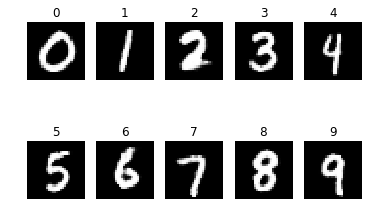

In [23]:
for i in range(10):
    mean_seed = np.reshape(means2[i], (1, 100))
    img = g_model.predict(mean_seed)
    plt.subplot(2,5,1+i)
    plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
    plt.title(str(i))
    plt.axis('off')
plt.show()

hasil rata-rata dari suatu kelas dikurangi dengan hasil rata-rata dari kelas lainya

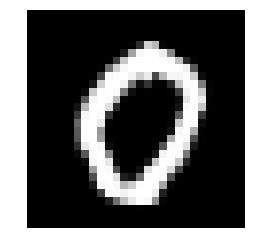

Predicted label is [0]


In [25]:
new_d = means[9] - means[1]
img = g_model.predict(np.reshape(new_d, (1, 100)))
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

pred = mnist_model.predict(img)
label = np.argmax(pred, axis=1)
print('Predicted label is %s' % label) 

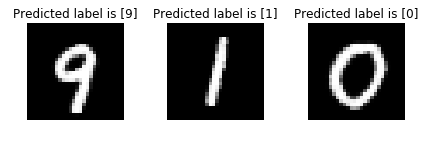

In [26]:
img = g_model.predict(np.reshape(means[9], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,1)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

img = g_model.predict(np.reshape( means[1], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,2)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 


new_d = means[9] - means[1]
img = g_model.predict(np.reshape(new_d, (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,3)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

plt.tight_layout() 
plt.show()

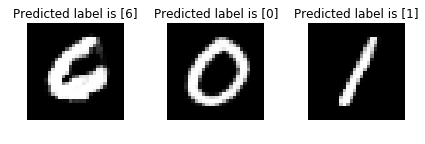

In [27]:
img = g_model.predict(np.reshape(means[6], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,1)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

img = g_model.predict(np.reshape( means[0], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,2)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 


new_d = means[6] - means[0]
img = g_model.predict(np.reshape(new_d, (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,3)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

plt.tight_layout() 
plt.show()

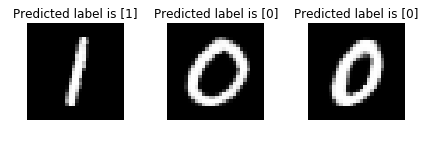

In [28]:
img = g_model.predict(np.reshape(means[1], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,1)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

img = g_model.predict(np.reshape( means[0], (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,2)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 


new_d = means[1] + means[0]
img = g_model.predict(np.reshape(new_d, (1, 100)))
label = np.argmax(mnist_model.predict(img), axis=1)
plt.subplot(1,3,3)
plt.imshow(np.reshape(img, (28,28,)),cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.title('Predicted label is %s' % label) 

plt.tight_layout() 
plt.show()